## 0. 导入依赖 (Import Dependencies)

这里导入了 v4 版本中用到的基础库，同时新增了 v2.0 需要的多模态处理模块。
我们从 `MiCoGPT.utils_vCross` 中导入自定义的模型配置、模型主体和数据整理器。

In [1]:
import os
import torch
import warnings
from pickle import load
from argparse import Namespace
from configparser import ConfigParser
from importlib.resources import files

import pandas as pd
from torch.utils.data import Subset

from transformers import (
    Trainer,
    TrainingArguments,
)
from transformers.trainer_callback import EarlyStoppingCallback

# --- v2.0 新增模块 ---
# 导入自定义的模型和配置类
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForCausalLM
# 导入自定义的数据整理器 (处理多模态输入)
from MiCoGPT.utils_vCross.collator_vCross import MiCoGPTDataCollator

# 复用 v4 的工具函数
from MiCoGPT.utils.pretrain import build_prior_matrix_from_npz
from MiCoGPT.utils.tools import split_train_val_by_project_stratified

warnings.filterwarnings("ignore")

## 1. 基本参数设置 (Basic Parameters)

设置输入数据路径、输出目录以及先验知识库路径。
请根据实际情况修改 `input` (语料库) 和 `prior_npz` (先验矩阵) 的路径。

In [2]:
args = Namespace(
    # 语料库文件路径 (v2.0 格式)
    input="../data/vCross/ResMicroDB_90338_vCross.pkl",
    
    # 模型输出目录
    output="../models/pretrain_vCross_base",
    log="../logs/pretrain_vCross_base",
    
    # 先验知识库路径 (DNABERT-S 提取的 Genus Embeddings)
    # 注意：使用 PCA 降维后的 256 维版本
    prior_npz= files("MiCoGPT")/"resources"/"genus_embeddings_256.npz"
)

# 验证集比例
VAL_RATIO = 0.10

## 2. 载入语料库 (Load Corpus)

加载预处理好的 `MiCoGPTCorpus_vCross` 对象。
v2.0 的语料库不仅包含物种序列，还包含丰度信息 (Value) 和环境信息 (Condition)。

In [3]:
print(f"Loading corpus from {args.input} ...")
all_corpus = load(open(args.input, "rb"))

# 检查是否包含了 metadata 和 encoders
if not hasattr(all_corpus, "meta_encoders") or not all_corpus.meta_encoders:
    print("[Warning] Corpus object does not contain meta_encoders. Please check if it was constructed correctly.")
    # 如果确实缺失，可以尝试加载独立的 joblib 文件 (如果存在)
    # import joblib
    # all_corpus.meta_encoders = joblib.load(args.input.replace(".pkl", "_encoders.joblib"))

# 选择 Split_Group 为 A 的样本进行训练 (根据项目需求调整)
if all_corpus.metadata is not None and "Split_Group" in all_corpus.metadata.columns:
    print("Subsetting corpus by Split_Group == 'A'...")
    corpus = all_corpus.subset_by_metadata(lambda df: df["Split_Group"] == "A")
else:
    print("Using full corpus (no Split_Group found or metadata missing).")
    corpus = all_corpus
    
tokenizer = all_corpus.tokenizer

print("Number of samples in all_corpus:", len(all_corpus))
print("Number of samples in corpus (Training subset):", len(corpus))
print("Tokenizer vocab size:", tokenizer.vocab_size)

Loading corpus from ../data/vCross/ResMicroDB_90338_vCross.pkl ...
Subsetting corpus by Split_Group == 'A'...
[subset_by_metadata] Selected 74557 samples out of 90338.
Number of samples in all_corpus: 90338
Number of samples in corpus (Training subset): 74557
Tokenizer vocab size: 1121


## 3. 提取环境元数据信息 (Extract Metadata Info)

为了构建 `Condition Embeddings`，我们需要知道有多少个环境列，以及每一列有多少个不同的取值 (Vocab Size)。
注意：虽然我们在构造时生成了 `meta_encoders.joblib`，但 `corpus` 对象本身通常已经包含了 `meta_encoders` 属性，所以直接从对象中获取即可。

In [4]:
# 从 corpus 中获取元数据编码器
# corpus 是 Subset，需要访问 corpus.dataset 来获取原始属性
if isinstance(corpus, Subset):
    base_corpus = corpus.dataset
else:
    base_corpus = corpus

condition_cols = list(base_corpus.meta_encoders.keys())
condition_vocab_sizes = [len(le.classes_) + 1 for le in base_corpus.meta_encoders.values()]
# +1 是为了给 Unknown/Padding 留位置

print("Condition Columns:", condition_cols)
print("Condition Vocab Sizes:", condition_vocab_sizes)

Condition Columns: ['Sample_Site']
Condition Vocab Sizes: [11]


## 4. 加载先验知识库 (Load Prior Knowledge Base)

加载 `.npz` 文件，获取微生物的进化特征向量。
这些向量将作为 Cross-Attention 的 Key/Value，帮助模型理解陌生物种。

In [5]:
# 基础配置读取 (用于获取 n_embd 等参数)
cfg = ConfigParser()
cfg.read(files("MiCoGPT")/"resources/config.ini")
n_embd = cfg.getint("GPT2", "n_embd")

if os.path.exists(args.prior_npz):
    print(f"Loading prior matrix from {args.prior_npz} ...")
    # build_prior_matrix_from_npz 返回的是对齐到 tokenizer vocab 的矩阵
    # 这对于 Cross-Attention 也是可用的，虽然会有很多零向量(padding)，
    # 但 Attention 机制会自动处理。
    
    # 强制转为 str，防止 PosixPath 导致的潜在问题
    prior_matrix, _, _ = build_prior_matrix_from_npz(
        tokenizer, str(args.prior_npz), tokenizer.vocab_size, n_embd
    )
else:
    print(f"[Warning] Prior NPZ not found at {args.prior_npz}. Initializing random prior matrix for testing.")
    prior_matrix = torch.randn(tokenizer.vocab_size, n_embd)

Loading prior matrix from /home/cml_lab/caiqy/project/MiCoGPT/MiCoGPT/resources/genus_embeddings_256.npz ...
[prior] npz genus: 1117
[prior] prior unique token_id: 1117
[prior] missing genus: 0


## 5. 构建 MiCoGPT v2.0 模型 (Build Model)

实例化 `MiCoGPTConfig` 和 `MiCoGPTForCausalLM`。
这里我们将 `add_cross_attention` 设为 True，并传入分箱数量和环境维度。

In [6]:
# 1. 构建配置
gpt2_config_dict = {
    "vocab_size":   tokenizer.vocab_size,
    "n_positions":  cfg.getint("GPT2", "n_positions"),
    "n_embd":       cfg.getint("GPT2", "n_embd"),
    "n_layer":      cfg.getint("GPT2", "n_layer"),
    "n_head":       cfg.getint("GPT2", "n_head"),
    "bos_token_id": tokenizer.bos_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "pad_token_id": tokenizer.pad_token_id,
}

config = MiCoGPTConfig(
    num_bins=52,                        # 0-51 共 52 个等级
    condition_vocab_sizes=condition_vocab_sizes, # 环境元数据维度
    prior_matrix_path=args.prior_npz,   # 记录路径
    **gpt2_config_dict
)

# 2. 实例化模型
model = MiCoGPTForCausalLM(config)

# 3. 注入先验矩阵 (作为 Cross-Attention 的 Memory)
model.set_prior_matrix(prior_matrix)

print("Model Config:", config)
print("Model Architecture:", model)

Model Config: MiCoGPTConfig {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "attn_pdrop": 0.1,
  "bos_token_id": 2,
  "condition_vocab_sizes": [
    11
  ],
  "embd_pdrop": 0.1,
  "eos_token_id": 3,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 256,
  "n_head": 8,
  "n_inner": null,
  "n_layer": 8,
  "n_positions": 512,
  "num_bins": 52,
  "pad_token_id": 0,
  "prior_matrix_path": "/home/cml_lab/caiqy/project/MiCoGPT/MiCoGPT/resources/genus_embeddings_256.npz",
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.33.3",
  "use_cache": true,
  "vocab_size": 1121
}

Model Architecture: MiCoGPTForCausalLM(
  (transformer): GPT2Model(
    (wte): Embedding(112

## 6. 初始化数据整理器 (Data Collator)

使用我们编写的 `MiCoGPTDataCollator`，它负责把 dataset 里的 list 数据整理成 Tensor，
并处理多模态数据的 Padding 和 Stack。

In [7]:
collator = MiCoGPTDataCollator(
    tokenizer=tokenizer,
    max_length=config.n_positions
)

## 7. 划分训练集和验证集 (Split Train/Val)

使用分层抽样策略，按 Project_ID 划分，防止数据泄露。

In [8]:
# 获取 metadata (兼容 Subset)
if isinstance(corpus, Subset):
    metadata = corpus.dataset.metadata
else:
    metadata = corpus.metadata

# 检查是否可以按 Project_ID 分层
if metadata is not None and "Project_ID" in metadata.columns:
    print("Using stratified split by Project_ID...")
    train_dataset, val_dataset = split_train_val_by_project_stratified(
        corpus,
        val_ratio=VAL_RATIO,
        project_col="Project_ID"
    )
else:
    print("Project_ID not found or metadata missing. Using random split...")
    val_size = int(len(corpus) * VAL_RATIO)
    train_size = len(corpus) - val_size
    # 使用 torch.utils.data.random_split
    train_dataset, val_dataset = torch.utils.data.random_split(
        corpus, [train_size, val_size], generator=torch.Generator().manual_seed(42)
    )

Using stratified split by Project_ID...
[split] total_samples=74557, target_val~7456
[split] eligible_projects=304, eligible_samples=74367
[split] ineligible_projects=16, ineligible_samples=190
[split] actual_val=7456 (target~7456), train=67101


## 8. 训练参数 (Training Arguments)

设置 Batch Size, Learning Rate, Epochs 等。

In [9]:
training_args = TrainingArguments(
    output_dir=f"{args.output}/checkpoints",
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    
    learning_rate=1e-3,
    weight_decay=0.01,
    
    logging_dir=args.log,
    logging_steps=100,
    save_steps=500,
    eval_steps=500,
    evaluation_strategy="steps",
    save_strategy="steps",
    
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    
    # [NFS Fix] 在 NFS (网络文件系统) 上，多进程 DataLoader 容易导致 .nfs 文件锁死错误
    # 将 num_workers 设为 0 可以避免 "Device or resource busy" 错误
    dataloader_num_workers=0,
    dataloader_pin_memory=True,
    fp16=torch.cuda.is_available(), # 如果有 GPU 则开启半精度
    no_cuda=not torch.cuda.is_available(),
    
    # [vCross] 显式开启 TensorBoard 日志记录
    report_to=["tensorboard"],
)

## 9. 初始化 Trainer 并开始训练 (Start Training)

将所有积木组装在一起：模型、参数、数据、整理器。

In [ ]:
# --- [New] 手动测试 Step 0 的 Validation Loss ---
print("Evaluating initial model (Step 0) ...")

# 调用 evaluate() 会使用 Trainer 初始化时传入的 eval_dataset 进行评估
init_eval_metrics = trainer.evaluate()

print("Initial Eval Metrics:", init_eval_metrics)

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
)

# 开始训练
trainer.train()

Step,Training Loss,Validation Loss
500,5.050400,4.800498
1000,4.858200,4.651763
1500,4.816400,4.560880
2000,4.739700,4.494757
2500,4.680800,4.427790
3000,4.653100,4.379779
3500,4.575300,4.334867
4000,4.518000,4.290587
4500,4.507900,4.260910
5000,4.478300,4.224670


TrainOutput(global_step=42500, training_loss=4.1361175300149355, metrics={'train_runtime': 10769.1866, 'train_samples_per_second': 311.542, 'train_steps_per_second': 9.736, 'total_flos': 3.521008999858176e+16, 'train_loss': 4.1361175300149355, 'epoch': 20.27})

## 10. 保存模型与日志分析 (Save Model & Log Analysis)

除了保存模型权重，我们还将训练过程中的 Log History 导出为 JSON，并绘制 Loss 曲线以便直观查看训练效果。

In [ ]:
import json
import matplotlib.pyplot as plt

# 1. 保存模型和分词器
trainer.save_model(args.output)
tokenizer.save_pretrained(args.output)
print(f"Model saved to {args.output}")

# 2. 导出训练日志
log_history = trainer.state.log_history
log_path = f"{args.output}/training_logs.json"
with open(log_path, "w") as f:
    json.dump(log_history, f, indent=2)
print(f"Training logs saved to {log_path}")

# 3. 绘制 Loss 曲线
# 提取训练集 Loss
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]

# 提取验证集 Loss
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.figure(figsize=(10, 6))
if train_steps:
    plt.plot(train_steps, train_loss, label="Training Loss", alpha=0.7)
if eval_steps:
    plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o", linestyle="--")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# 保存图片
plt.savefig(f"{args.output}/loss_curve.png")
print(f"Loss curve saved to {args.output}/loss_curve.png")
plt.show()

✅ Hotfix applied: 'save_vocabulary' method has been injected into the tokenizer.
Model and Tokenizer saved to ../models/pretrain_vCross_base


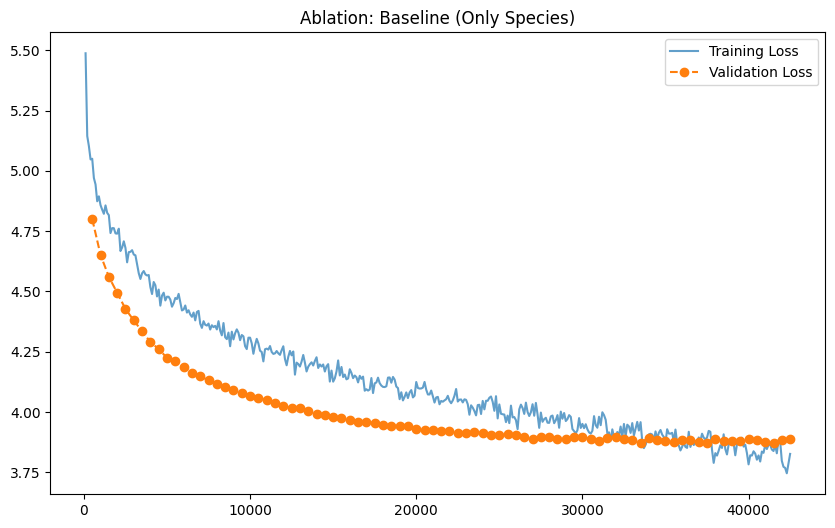

In [11]:
import os
import json
import types
import matplotlib.pyplot as plt

# --- 1. 临时补丁 (Hotfix) ---
# 在内存中定义缺失的 save_vocabulary 方法
def save_vocabulary_patch(self, save_directory: str, filename_prefix: str = None):
    if not os.path.isdir(save_directory):
        return
    
    vocab_file = os.path.join(
        save_directory, (filename_prefix + "-" if filename_prefix else "") + "vocab.json"
    )
    
    with open(vocab_file, "w", encoding="utf-8") as f:
        json.dump(self.vocab, f, ensure_ascii=False)
        
    return (vocab_file,)

# 将方法动态绑定到当前内存中的 tokenizer 类上
# 这样不需要重启内核，当前的 tokenizer 实例就能立刻拥有这个方法
tokenizer.__class__.save_vocabulary = save_vocabulary_patch
print("✅ Hotfix applied: 'save_vocabulary' method has been injected into the tokenizer.")

# --- 2. 执行保存与分析逻辑 ---

# 保存模型
trainer.save_model(args.output)
# 现在这一步应该能成功了，因为它会调用我们刚刚注入的 patch 方法
tokenizer.save_pretrained(args.output)
print(f"Model and Tokenizer saved to {args.output}")

# 导出日志
log_history = trainer.state.log_history
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.figure(figsize=(10, 6))
if train_steps: plt.plot(train_steps, train_loss, label="Training Loss", alpha=0.7)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o", linestyle="--")
plt.title("Ablation: Baseline (Only Species)")
plt.legend()
plt.savefig(f"{args.output}/loss_curve.png")
plt.show()